In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

from IPython.display import Image, display

import os
from dotenv import load_dotenv

from langchain_tavily import TavilySearch

In [2]:
# Load .env file
load_dotenv()

# Initialize State 
class State(TypedDict):
    messages: Annotated[list, add_messages]

### LLMs

In [ ]:
# LLMs
llm_google = ChatGoogleGenerativeAI(model='gemini-2.5-flash')
llm_groq = ChatGroq(model='llama3-8b-8192')

llm = llm_google # Set default llm

### TOOLS

In [4]:
search_tool = TavilySearch(max_results=2)
search_tool.invoke("Agentic AI for beginners")

{'query': 'Agentic AI for beginners',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.youtube.com/watch?v=CnXdddeZ4tQ',
   'title': 'Agentic AI Tutorial for Beginners | Langgraph Tutorial',
   'content': "Agentic AI Tutorial for Beginners | Langgraph Tutorial\ncodebasics\n1370000 subscribers\n2217 likes\n108549 views\n27 Jun 2025\nLearn Agentic AI using a popular framework langgraph. In this agenti ai tutorial for beginners, we will start with agentic AI basics and then we will dive deeper into langgraph by covering a wide range of topics.\n\n👉 Check out PyCharm, the IDE built for data science and AI/ML professionals: https://jb.gg/try-pycharm-now\n\n👉 Download PyCharm and use it for free forever, plus a one-month Pro subscription is included. \n\nCode: https://github.com/codebasics/langgraph-crash-course\n\n00:00 Introduction \n00:40 Agentic AI Basics\n00:00 What is Langgraph\n07:41 Langchain vs Langgraph\n13:08 Installation and Setup\n1

In [5]:
# Tool creation using a custom function
def calculate_bill_split(total_bill: float, num_people: int, tip_percentage: int) -> float:
    """
    Calculates the split amount for each person in the bill including the tip.
    
    Args:
        total_bill (float): The total bill amount.
        num_people (int): The number of people sharing the bill.
        tip_percentage (int): The tip percentage to be added to the bill.
    
    Returns:
        float: The amount each person needs to pay.
        
    """
    if num_people == 0:
        return 0.0
    total_with_tip = total_bill + (total_bill * tip_percentage / 100)
    return total_with_tip / num_people  

In [6]:
tools = [search_tool, calculate_bill_split]

In [7]:
# binding llm with tools
llm_with_tools = llm.bind_tools(tools)

### GRAPH

Changes: 
-The edge from tools to END will instead go back from tools to the tool_calling_llm


In [8]:
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [9]:
'''
BUUILDING THE GRAPH
'''
memory = MemorySaver()

graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("tool_call_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

# Edges
graph_builder.add_edge(START, "tool_call_llm")
graph_builder.add_conditional_edges(
    "tool_call_llm",
    tools_condition
    
)
graph_builder.add_edge("tools", "tool_call_llm") # Loop back to tool_call_llm after using a tool

# Compile
graph = graph_builder.compile(checkpointer=memory)

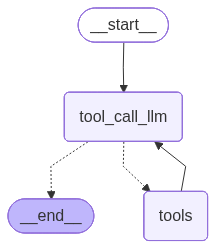

In [10]:
#visualize Graph
def display_graph():
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Error displaying graph: {e}")

display_graph()


### Execute

In [12]:
config = {"configurable": {"thread_id": "1"}} #unique id

response = graph.invoke({"messages": "Hello I am dining with three people"}, config=config)

for msg in response['messages']:
    msg.pretty_print()


================================ Human Message =================================

Hello I am dining with three people
================================== Ai Message ==================================

Hi there! How much is the total bill and would you like to add a tip? If so, what percentage?


In [14]:
response = graph.invoke({"messages": "The bill is 26.70 and we want to give a fifteen percent tip"}, config=config)

for msg in response['messages']:
    msg.pretty_print()


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 16.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.ge

KeyboardInterrupt: 